In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, IntegerLookup
from keras.models import Model
from keras import initializers
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2


In [9]:
prefs = pd.read_csv("../../datasets/ml-latest-small/ratings.csv", sep=",")
columns = ['userId', 'movieId', 'rating', 'timestamp']
#prefs = pd.read_csv("../../datasets/ml-100k/u.data", sep="\t", names=columns)
prefs.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
n_users = prefs.iloc[:,0].unique().size
n_items = prefs.iloc[:,1].unique().size
n_prefs = prefs.iloc[:,1].size

print("Number of users",n_users)
print("Number of items",n_items)
print("Number of prefs",n_prefs)

Number of users 610
Number of items 9724
Number of prefs 100836


#Different Architectures
**Architecture 1**

In [13]:
n_factors = 30

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
# Embedding layer
user_embedding = Embedding(input_dim = n_users, output_dim = n_factors, name = 'mf_embedding_user')(user_input)
item_embedding = Embedding(input_dim = n_items, output_dim = n_factors, name = 'mf_embedding_item')(item_input)   

# Concatenate the embeddings 
conc = Concatenate()([user_embedding, item_embedding])
out = Dense(1)(conc)

# Create model and compile it
model = Model(
    inputs = [user_input, item_input],
    outputs = out,
)

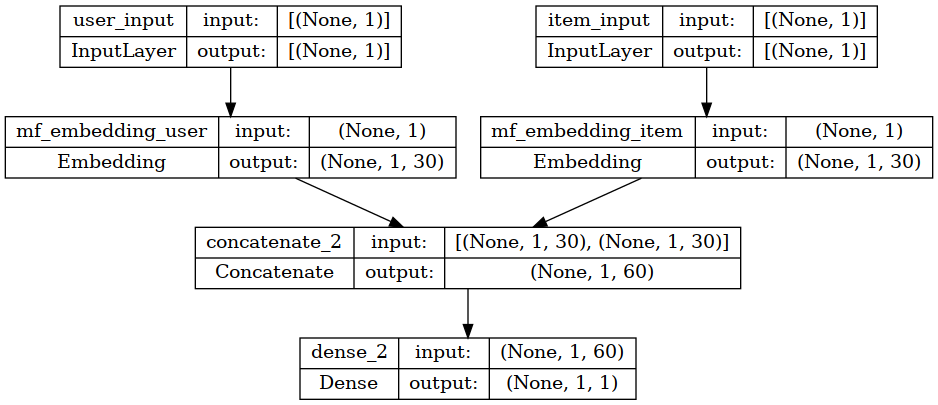

In [14]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

**Architecture 2**

- Vary the number of hidden units from 1 to 16. What do you observe in validation accuracy?
- Add more hidden layers. 
- Addtion a hidden layer (compared to architecture 1) clearly leads to better results. This cannot be compensated by increasing the number of units in the output layer in architecture 1.

In [21]:
n_factors = 30

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
# Embedding layer
user_embedding = Embedding(input_dim = n_users, output_dim = n_factors, name = 'mf_embedding_user')(user_input)
item_embedding = Embedding(input_dim = n_items, output_dim = n_factors, name = 'mf_embedding_item')(item_input)   

# Concatenate the embeddings 
conc = Concatenate()([user_embedding, item_embedding])

fc2 = Dense(50)(conc)

out = Dense(1)(fc2)

# Create model and compile it
model = Model(
    inputs = [user_input, item_input],
    outputs = out,
)

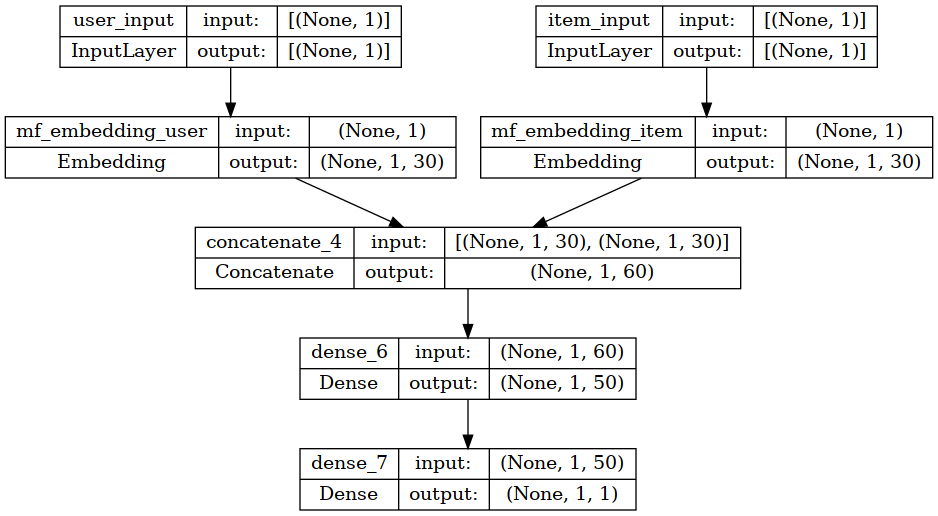

In [22]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

**Architecture 3**
- Dot product operation does not seem to have an additional advantage. Actually, it seems to make things worse.

In [36]:
n_factors = 2

user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
# Embedding layer
user_embedding = Embedding(input_dim = n_users, output_dim = n_factors, name = 'mf_embedding_user')(user_input)
item_embedding = Embedding(input_dim = n_items, output_dim = n_factors, name = 'mf_embedding_item')(item_input)   

user_factors = Flatten()(user_embedding)
item_factors = Flatten()(item_embedding)

# Take the dot product of the embeddings 
dot = Dot(axes=1)([user_factors, item_factors])
#out = Dense(1)(dot)

# Create model and compile it
model = Model(
    inputs = [user_input, item_input],
    outputs = dot,
)



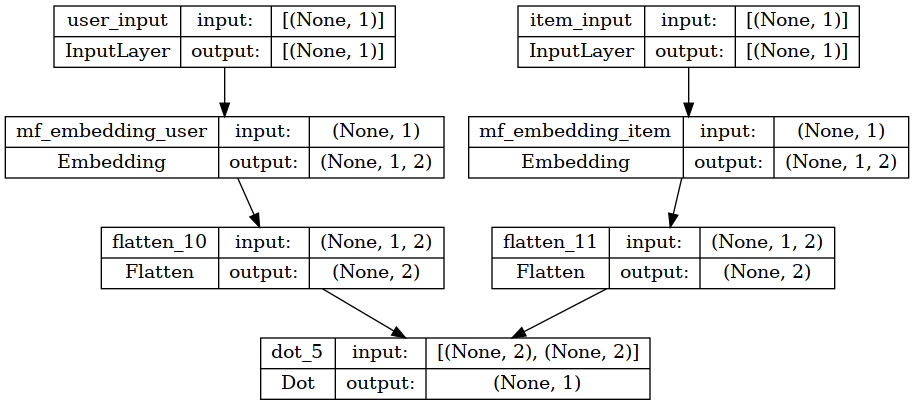

In [37]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(model, "model.png",show_shapes=True)

In [15]:
le = LabelEncoder()
x1 = le.fit_transform(prefs['userId'].values)
x2 = le.fit_transform(prefs['movieId'].values)

y = prefs.iloc[:,2]
#user_ids_vocabulary = tf.keras.layers.IntegerLookup(mask_token=None)
#user_ids_vocabulary.adapt(ratings.map(lambda x: x["user_id"]))

In [38]:
model.compile(
  loss='MSE',
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
  metrics=['MAE'],
)
history = model.fit([x1,x2], y, epochs=5, validation_split=.05)

Epoch 1/5
2994/2994 [==============================] - 15s 5ms/step - loss: 6.0017 - MAE: 2.0149 - val_loss: 13.2455 - val_MAE: 3.5032
Epoch 2/5
2994/2994 [==============================] - 20s 7ms/step - loss: 1.4010 - MAE: 0.8819 - val_loss: 13.2274 - val_MAE: 3.4990
Epoch 3/5
2994/2994 [==============================] - 28s 9ms/step - loss: 0.9998 - MAE: 0.7545 - val_loss: 13.2212 - val_MAE: 3.4972
Epoch 4/5
2994/2994 [==============================] - 30s 10ms/step - loss: 0.8663 - MAE: 0.7136 - val_loss: 13.2178 - val_MAE: 3.4963
Epoch 5/5
2994/2994 [==============================] - 31s 10ms/step - loss: 0.7957 - MAE: 0.6873 - val_loss: 13.2150 - val_MAE: 3.4961


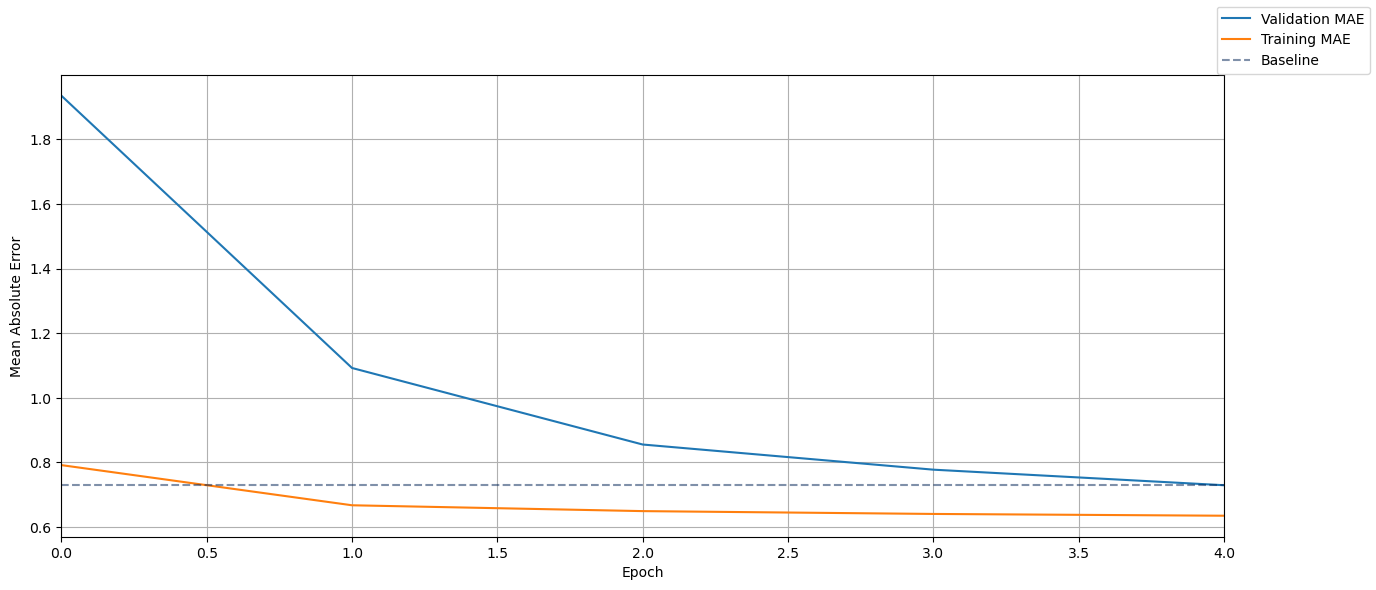

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_MAE'], label='Validation MAE')
ax.plot(history.epoch, history.history['MAE'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();


In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError

# Load the MovieLens dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.data'
columns = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv(url, sep='\t', names=columns)
df = prefs
# Extract the number of users and items
num_users = df['userId'].nunique()
num_items = df['movieId'].nunique()
x1 = le.fit_transform(df['userId'].values)
x2 = le.fit_transform(df['movieId'].values)
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Define the matrix factorization model
def build_matrix_factorization_model(num_users, num_items, embedding_size=30):
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')

    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, input_length=1)(user_input)
    item_embedding = Embedding(input_dim=num_items, output_dim=embedding_size, input_length=1)(item_input)

    user_flat = Flatten()(user_embedding)
    item_flat = Flatten()(item_embedding)

    dot_product = Dot(axes=1)([user_flat, item_flat])

    model = Model(inputs=[user_input, item_input], outputs=dot_product)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error', metrics=[MeanSquaredError()])
    
    return model

# Build and compile the model
model = build_matrix_factorization_model(num_users, num_items, embedding_size=30)
model.summary()

# Train the model
history = model.fit(
    x=[x1,x2],
    y=df['rating'],
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 embedding_20 (Embedding)       (None, 1, 30)        18300       ['user_input[0][0]']             
                                                                                                  
 embedding_21 (Embedding)       (None, 1, 30)        291720      ['item_input[0][0]']             
                                                                                           

In [41]:
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156
